# Etude de marché pour le compte de l'entreprise "La poule qui chante" partie 2

Le but de ce projet sera d'effectuer une étude de marché dans l'optique du developpement de l'entreprise à l'international.
Ce notebook est le second d'une série de 2 notebooks.

# Réalisation des clusterings

## Import des librairies

In [482]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.collections as LineCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.text import Text
from matplotlib.legend_handler import HandlerBase
import plotly.express as px 
import plotly.graph_objs as go
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import decomposition
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import plotly.figure_factory as ff
from sklearn.decomposition import PCA

## Import des données

In [483]:
df_clustering = pd.read_csv('df_final_quanti.csv')

## Méthode 1 : Clustering avec les K-means

### Scaling des données

Les données nécessitent d'être normalisées et nous savons qu'il y a des outliers ainsi que l'absence de normalité dans la distribution de nos variables. Ces informations vont conditionner le choix de la méthode de scaling.
Ici, nous choisirons la méthode MaxAbsScaler car elle prend en compte nos outliers notamment l'Inde pour ce qui est de la variable population. 


In [484]:
# Scaling des données avec MaxAbsScaler

df_clustering.set_index('Zone', inplace=True)

mas = MaxAbsScaler()

df_clustering_mas = pd.DataFrame(mas.fit_transform(df_clustering),
                                       index=df_clustering.index,
                                       columns=df_clustering.columns)
df_clustering_mas.head()


,Population totale,PIB par habitant,Stabilité politique,% Volaille / Nourriture,% Volaille / Import,% d'utilisateurs web,% des revenus issus des taxes,Distance from France
Zone,,,,,,,,
Afghanistan,0.027113,0.016313,-1.000000,0.032209,0.026348,0.137391,0.228448,0.301726
Afrique du Sud,0.042587,0.100657,-0.100000,0.491564,0.234664,0.571647,0.097599,0.501996
Albanie,0.002154,0.101209,0.135714,0.098926,0.177028,0.635050,0.048953,0.086516
Allemagne,0.061746,0.419648,0.210714,0.157975,0.052285,0.858844,0.000000,0.047519
Angola,0.022273,0.057938,-0.117857,0.141871,0.274599,0.264604,0.111761,0.349461


### Détermination du nombre de clusters optimal

#### Méthode 1 : Méthode du coude

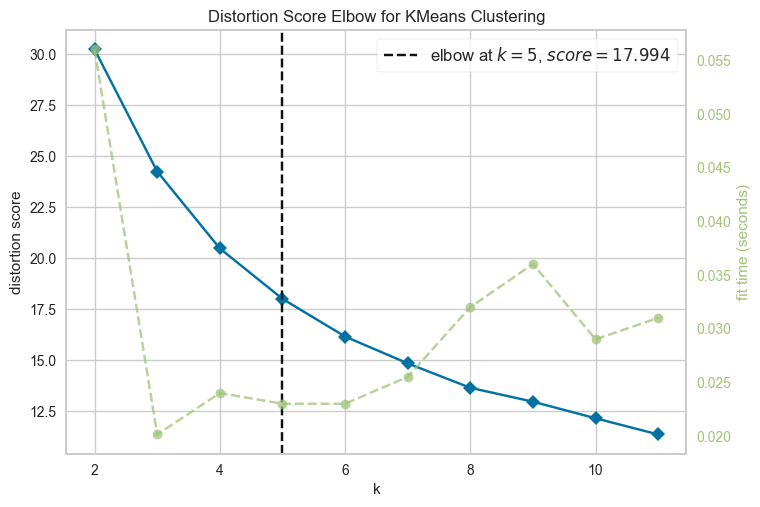

In [485]:
kmeans = KMeans(n_init=10)

visualizer = KElbowVisualizer(kmeans, k=(2, 12))
visualizer.fit(df_clustering_mas)
visualizer.show();

Le nombre optimal de clusters selon la méthode du coude est 5.

#### Méthode 2 : Score de silhouette 

In [486]:
# On crée une liste pour stocker les différents scores de silhouette
silhouette_scores = []

# On crée une boucle pour trouver le nombre de clusters qui a le plus haut score de silhouette
for n_clusters in range(2, 13):
    # Fitting du modèle de clustering KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(df_clustering_mas)
    
    # Calcul du score de silhouette et ajout à la liste 
    silhouette_avg = silhouette_score(df_clustering_mas, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print(f"For {n_clusters} clusters, the silhouette score is {silhouette_avg:.4f}")

For 2 clusters, the silhouette score is 0.3133
For 3 clusters, the silhouette score is 0.3103
For 4 clusters, the silhouette score is 0.2757
For 5 clusters, the silhouette score is 0.2898
For 6 clusters, the silhouette score is 0.2723
For 7 clusters, the silhouette score is 0.2829
For 8 clusters, the silhouette score is 0.2349
For 9 clusters, the silhouette score is 0.2646
For 10 clusters, the silhouette score is 0.2264
For 11 clusters, the silhouette score is 0.2738
For 12 clusters, the silhouette score is 0.2932


Le nombre de clusters idéal indiqué par cette méthode est 2, cependant, étant donné que le score pour 5 clusters est un des plus proches de 1, nous allons le conserver pour la suite de l'analyse.

### Implémentation du modèle

In [487]:
# On utilise les résultats de la méthode du coude k=5 et on fit avec nos données

cluster_model = KMeans(n_clusters=5, init='k-means++', random_state=21)
cluster_model.fit(df_clustering_mas)
clusters = cluster_model.predict(df_clustering_mas)

df_clustering_mas_kmeans = df_clustering_mas.copy()
df_clustering_mas_kmeans["Cluster"] = clusters

d:\Data_Analysis\Code\oc_part9\env_p9\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



#### Centroïdes

In [488]:
# On cherche les différences entre chaque cluster en les regroupant et en calculant les valeurs moyennes

df_clustering_mas_kmeans_centroids = df_clustering_mas_kmeans.groupby(
    "Cluster").mean()

In [489]:
# On crée une fonction qui vise à les plot sur une heatmap

def centroid_heatmap(df):
    return px.imshow(
        df,
        text_auto=".2f",
        aspect="auto",
        title="<b>Visualisation des centroïdes en heatmap</b>",
        color_continuous_scale=px.colors.sequential.Reds).update_layout(
            title_x=0.5).show()

centroid_heatmap(df_clustering_mas_kmeans_centroids)

In [490]:
# Calcul des valeurs médianes pour comparer avec les résultats affichés par la heatmap

round(df_clustering_mas_kmeans_centroids.median(), 2)

Population totale                0.02
PIB par habitant                 0.15
Stabilité politique              0.15
% Volaille / Nourriture          0.24
% Volaille / Import              0.06
% d'utilisateurs web             0.64
% des revenus issus des taxes    0.17
Distance from France             0.40
dtype: float64

#### Analyse des clusters à partir de la méthode K-means et des centroïdes

- Cluster 0 : Valeurs très proches des médianes pour la plupart des centroïdes sauf pour la stabilité politique. Ces pays représentent un marché intéressant notamment pour les donnés relatives à la consommation de volaille mais ils sont très instables politiquement. 

- Cluster 1 : Pays possédant la plus forte population mais avec un PIB par habitant très faible. Ils sont également instables politiquement et ne sont pas des grands consommateurs de volaille. Rien d'intéressant non plus pour le web et les taxes, et ce sont des pays plutôt éloignés de la France.

- Cluster 2 : Valeurs proches des médianes mais pays qui affichent la plus grande distance par rapport à la France. 

- Cluster 3 : Pays ayant une population plutôt élevée avec la plus haute stabilité politique une proximité avec la médiane pour les éléments relatifs à la consommation de produits volaillers. On observe un accès au Web très développé, un faible niveau de taxe et une proximité avec la France.

- Cluster 4 : Pays peu peuplés avec un PIB/hab et une stabilité médians. On observe que ce cluster regroupe les plus gros consommateurs de poulet mais ils sont éloignés de la France et peu ouvert au commerce avec des taxes élevées.


In [491]:
# On crée une liste qui trie les pays par clusters 

def liste_cluster(df):
    for i, list_item in enumerate(df["Cluster"].unique().tolist()):
        print("Cluster {}:".format(i) + "\n" +
              ", ".join(df[df["Cluster"] == i].index.sort_values()) + "\n")
        
liste_cluster(df_clustering_mas_kmeans)

Cluster 0:
Arabie saoudite, Arménie, Azerbaïdjan, Bosnie-Herzégovine, Bélarus, Colombie, Fédération de Russie, Grèce, Géorgie, Iraq, Israël, Jordanie, Kazakhstan, Liban, Macédoine du Nord, Maroc, Mexique, Moldova, Roumanie, Serbie, Thaïlande, Turquie, Ukraine

Cluster 1:
Afghanistan, Angola, Bangladesh, Burkina Faso, Cambodge, Cameroun, Congo, République du, Côte d'Ivoire, El Salvador, Ghana, Guatemala, Guinée-Bissau, Inde, Indonésie, Kenya, Lesotho, Madagascar, Malawi, Mali, Mongolie, Mozambique, Myanmar, Nicaragua, Népal, Ouganda, Philippines, Rwanda, République kirghize, Sri Lanka, Sénégal, Tanzanie, Timor-Leste, Togo, Zambie, Zimbabwe, Éthiopie, Îles Salomon

Cluster 2:
Afrique du Sud, Argentine, Australie, Belize, Brésil, Chili, Costa Rica, Fidji, Jamaïque, Kiribati, Malaisie, Maurice, Nouvelle-Zélande, Panama, Paraguay, Pérou, République dominicaine, Trinité-et-Tobago, Uruguay, Vanuatu

Cluster 3:
Albanie, Allemagne, Autriche, Belgique, Bulgarie, Canada, Chypre, Croatie, Danemark

In [492]:
# Nombre de pays par cluster 

print("Il y a {} pays dans le cluster 0.".format(df_clustering_mas_kmeans.loc[
    df_clustering_mas_kmeans["Cluster"] == 0].index.nunique()))
print("Il y a {} pays dans le cluster 1.".format(df_clustering_mas_kmeans.loc[
     df_clustering_mas_kmeans["Cluster"] == 1].index.nunique()))
print("Il y a {} pays dans le cluster 2.".format(df_clustering_mas_kmeans.loc[
     df_clustering_mas_kmeans["Cluster"] == 2].index.nunique()))
print("Il y a {} pays dans le cluster 3.".format(df_clustering_mas_kmeans.loc[
     df_clustering_mas_kmeans["Cluster"] == 3].index.nunique()))
print("Il y a {} pays dans le cluster 4.".format(df_clustering_mas_kmeans.loc[
     df_clustering_mas_kmeans["Cluster"] == 4].index.nunique()))

values = [df_clustering_mas_kmeans.loc[df_clustering_mas_kmeans["Cluster"] == i].index.nunique() for i in range(5)]
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title="Distribution des pays dans chaque cluster")
fig.show()

Il y a 23 pays dans le cluster 0.
Il y a 37 pays dans le cluster 1.
Il y a 20 pays dans le cluster 2.
Il y a 34 pays dans le cluster 3.
Il y a 9 pays dans le cluster 4.


Les clusters semblent cohérents et la répartition de l'effectif permet de les exploiter. Nous sommes parvenus à les labeliser et les hiérarchiser en fonction de leur degré de pertinence dans une optique de développement à l'international.

## Méthode 2 : Classification ascendante hiérarchique

In [493]:
def dendrogram(df_clustering_mas):
    return ff.create_dendrogram(
        df_clustering_mas,
        orientation="left",
        labels=df_clustering_mas.index,
        linkagefun=lambda x: linkage(df_clustering_mas, "ward", metric="euclidean")
    ).update_layout(width=950,
                    height=1700,
                    title="<b>Dendrogramme</b>",
                    title_x=0.5,
                    xaxis_title="Niveau de similarité").show()

In [494]:
dendrogram(df_clustering_mas)


La visualisation du dendrogramme permet de mettre en évidence une division en 3 à 6 clusters.

In [495]:
# Implémentation du clustering avec 6 clusters

Z = linkage(df_clustering_mas, method="ward", metric="euclidean")
clusters = fcluster(Z, 6, criterion="maxclust")

# Création de la colonne clusters

df_clustering_mas_cah = df_clustering_mas.copy()
df_clustering_mas_cah["Cluster"] = clusters

# Calcul des centroïdes

df_clustering_mas_cah_centroids = df_clustering_mas_cah.groupby(
   "Cluster").mean()


centroid_heatmap(df_clustering_mas_cah_centroids) 

In [496]:
# Calcul des médianes pour comparer

round(df_clustering_mas_cah_centroids.median(), 2)

Population totale                0.01
PIB par habitant                 0.14
Stabilité politique              0.13
% Volaille / Nourriture          0.24
% Volaille / Import              0.06
% d'utilisateurs web             0.61
% des revenus issus des taxes    0.28
Distance from France             0.40
dtype: float64

#### Analyse des clusters

- Cluster 1 : Un certain potentiel mais une forte instabilité politique. La plupart des valeurs sont proches des médianes voire supérieures.

- Cluster 2 : Une très forte population et une instabilité très élevée. Ce sont les pays les moins intéressants sur tous les points.

- Cluster 3 : Pays peu peuplés, pauvres, instables et ayant des valeurs inférieures aux médianes.

- Cluster 4 : Pays affichant le potentiel le plus intéressant sur la globalité des critères.

- Cluster 5 : Bon potentiel car grosse conso de volaille et imports élevés mais très éloignés de la France et haut niveau de taxes.

- Cluster 6 : Pays peu peuplés mais affichant des données intéressantes sur la consommation de volaille et les taxe. Ils importent cependant assez peu et sont surtout très éloignés de la France. 

In [497]:
# On affiche la liste des pays en fonction de leur cluster

for i, list_item in enumerate(
        df_clustering_mas_cah["Cluster"].unique().tolist(), 1):
    print("Cluster {}:".format(i) + "\n" + ", ".join(df_clustering_mas_cah[
        df_clustering_mas_cah["Cluster"] == i].index.sort_values()) + "\n")

Cluster 1:
Afrique du Sud, Arabie saoudite, Arménie, Azerbaïdjan, Bosnie-Herzégovine, Brésil, Bélarus, Colombie, El Salvador, Fédération de Russie, Guatemala, Géorgie, Indonésie, Iraq, Israël, Jordanie, Liban, Macédoine du Nord, Maroc, Mexique, Moldova, Myanmar, Nicaragua, Paraguay, Pérou, Thaïlande, Turquie, Ukraine

Cluster 2:
Afghanistan, Bangladesh, Burkina Faso, Cameroun, Côte d'Ivoire, Guinée-Bissau, Inde, Kenya, Madagascar, Malawi, Mali, Mozambique, Népal, Ouganda, Philippines, Tanzanie, Togo, Zimbabwe, Éthiopie

Cluster 3:
Angola, Botswana, Cabo Verde, Cambodge, Congo, République du, Gabon, Ghana, Kazakhstan, Kiribati, Lesotho, Mongolie, Namibie, Rwanda, République kirghize, Sri Lanka, Sénégal, Timor-Leste, Vanuatu, Zambie, Îles Salomon

Cluster 4:
Albanie, Allemagne, Autriche, Belgique, Bulgarie, Canada, Chypre, Croatie, Danemark, Espagne, Estonie, Finlande, France, Grèce, Hongrie, Irlande, Islande, Italie, Lettonie, Lituanie, Luxembourg, Malte, Norvège, Pays-Bas, Pologne, Por

In [498]:
# Nombre de pays par cluster

print("Il y a {} pays dans le cluster 1.".format(df_clustering_mas_cah.loc[
    df_clustering_mas_cah["Cluster"] == 1].index.nunique()))
print("Il y a {} pays dans le cluster 2.".format(df_clustering_mas_cah.loc[
    df_clustering_mas_cah["Cluster"] == 2].index.nunique()))
print("Il y a {} pays dans le cluster 3.".format(df_clustering_mas_cah.loc[
   df_clustering_mas_cah["Cluster"] == 3].index.nunique()))
print("Il y a {} pays dans le cluster 4.".format(df_clustering_mas_cah.loc[
    df_clustering_mas_cah["Cluster"] == 4].index.nunique()))
print("Il y a {} pays dans le cluster 5.".format(df_clustering_mas_cah.loc[
    df_clustering_mas_cah["Cluster"] == 5].index.nunique()))
print("Il y a {} pays dans le cluster 6.".format(df_clustering_mas_cah.loc[
    df_clustering_mas_cah["Cluster"] == 6].index.nunique()))

Il y a 28 pays dans le cluster 1.
Il y a 19 pays dans le cluster 2.
Il y a 20 pays dans le cluster 3.
Il y a 37 pays dans le cluster 4.
Il y a 5 pays dans le cluster 5.
Il y a 14 pays dans le cluster 6.


In [499]:
values2 = [df_clustering_mas_cah.loc[df_clustering_mas_cah["Cluster"] == i].index.nunique() for i in range(1, 7)]
labels2 = ['Cluster {}'.format(i) for i in range(1, 7)]

fig2 = go.Figure(data=[go.Pie(labels=labels2, values=values2)])
fig2.update_layout(title="Distribution des pays dans chaque cluster")


## Comparaison entre les résultats des 2 méthodes de clustering

Les deux clusters retenus sont le cluster 3 pour la méthode kmeans et le cluster 4 pour la CAH.

In [500]:
liste_kmeans = df_clustering_mas_kmeans.loc[df_clustering_mas_kmeans["Cluster"] ==
                                      3].index.tolist()
liste_cah = df_clustering_mas_cah.loc[df_clustering_mas_cah["Cluster"] ==
                                        4].index.tolist()

difference_cluster = list(set(liste_cah).difference(liste_kmeans))

print("Il y a " + str(len(difference_cluster)) +
      " en plus pour la CAH par rapport aux pays de liste_km.")
print()
print(str(sorted(list(difference_cluster))))

Il y a 3 en plus pour la CAH par rapport aux pays de liste_km.

['Grèce', 'Roumanie', 'Serbie']


Après analyse ces 3 pays ne constituent pas une opportunité d'installation donc nous conserverons les pays proposés par la méthode kmeans.

## Sélection finale de pays

In [501]:
# Rappel de la liste des pays 

df_cluster_3 = df_clustering_mas_kmeans[df_clustering_mas_kmeans["Cluster"] == 3]
zones_cluster_3 = df_cluster_3.index.tolist()
print("Liste des pays sélectionnés :")
print(", ".join(zones_cluster_3))


Liste des pays sélectionnés :
Albanie, Allemagne, Autriche, Belgique, Bulgarie, Canada, Région administrative spéciale de Macao, Chine, Chypre, Croatie, Danemark, Espagne, Estonie, Finlande, France, Hongrie, Irlande, Islande, Italie, Lettonie, Lituanie, Luxembourg, Malte, Norvège, Pays-Bas, Pologne, Portugal, Royaume-Uni, République slovaque, Slovénie, Suisse, Suède, République tchèque, Émirats arabes unis, États-Unis


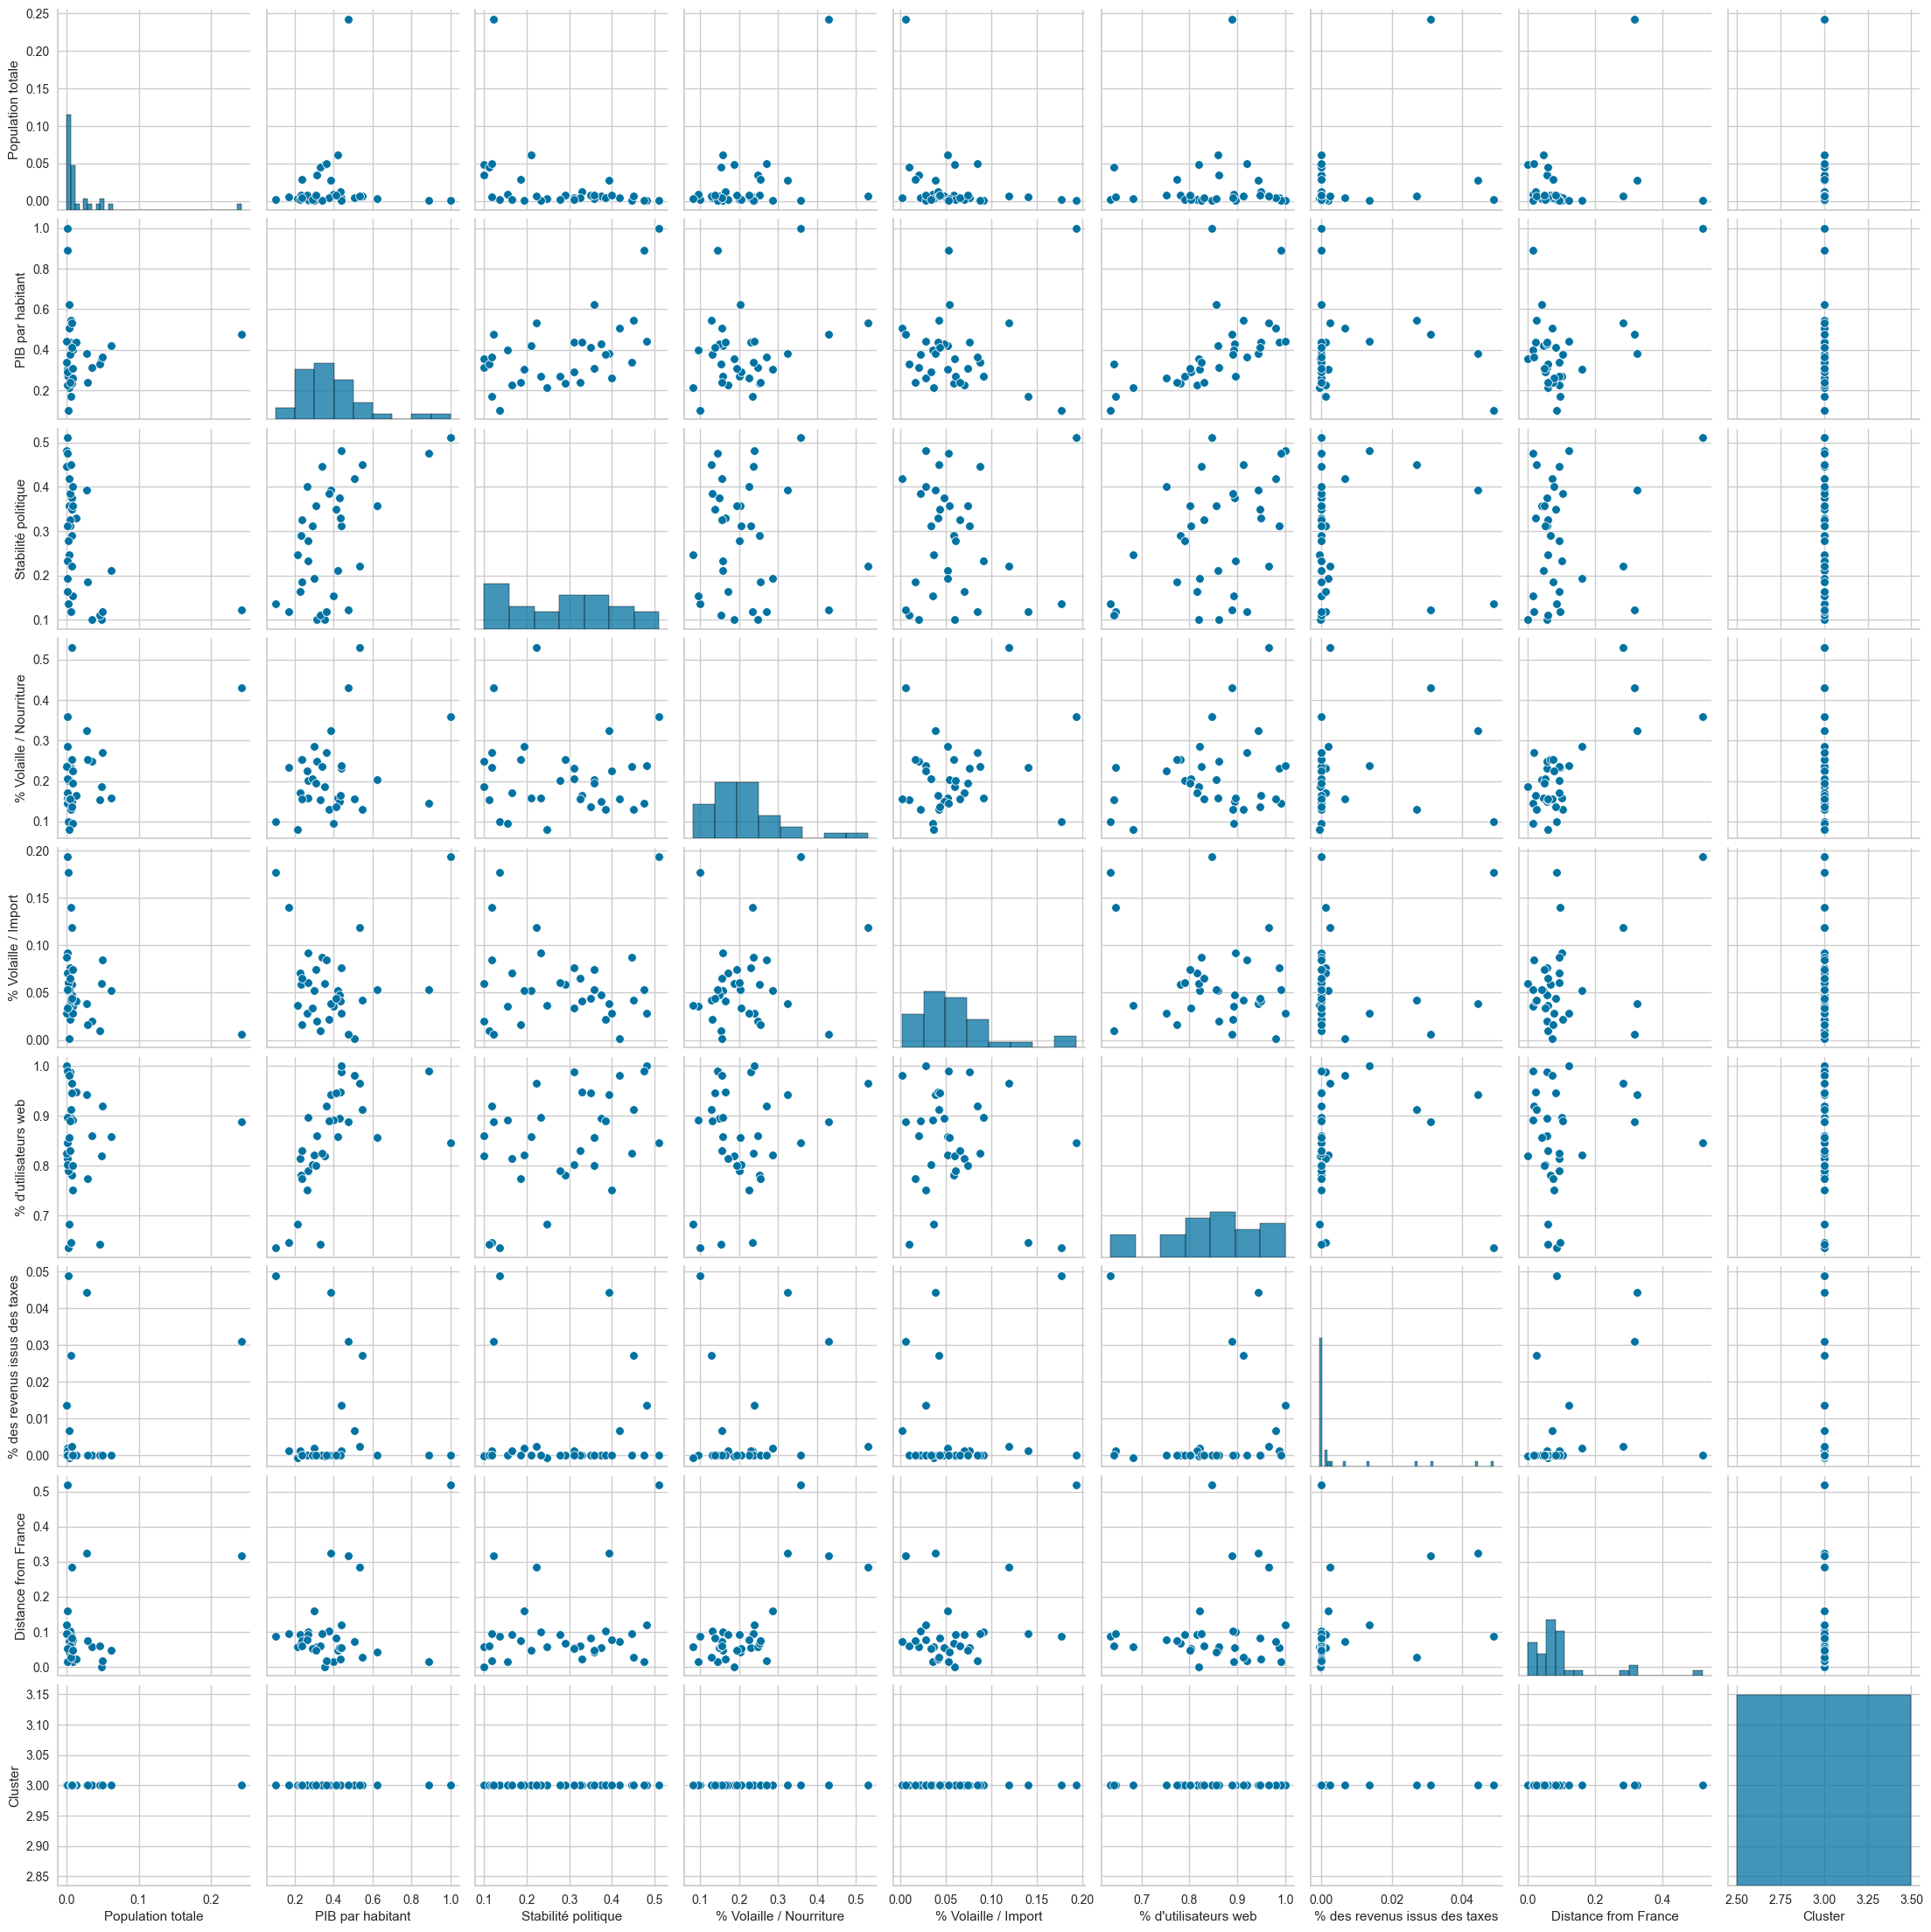

In [502]:
# On affiche un pairplot pour visualiser le cluster

cluster_final = df_clustering_mas_kmeans[df_clustering_mas_kmeans["Cluster"] == 3]
sns.pairplot(cluster_final)
plt.show()

## Analyse par composantes principales (ACP)

Nous allons effectuer une ACP afin de tenter d'affiner notre analyse sur le cluster final.

In [503]:
# Affichage des données à partir desquelles nous réaliserons l'ACP

cluster_final.drop('Cluster', axis=1, inplace=True)
cluster_final.head()

,Population totale,PIB par habitant,Stabilité politique,% Volaille / Nourriture,% Volaille / Import,% d'utilisateurs web,% des revenus issus des taxes,Distance from France
Zone,,,,,,,,
Albanie,0.002154,0.101209,0.135714,0.098926,0.177028,0.635050,0.048953,0.086516
Allemagne,0.061746,0.419648,0.210714,0.157975,0.052285,0.858844,0.000000,0.047519
Autriche,0.006589,0.429294,0.375000,0.149540,0.047756,0.894973,0.000000,0.055933
Belgique,0.008531,0.399752,0.153571,0.095092,0.035817,0.892326,0.000000,0.014293
Bulgarie,0.005306,0.169493,0.117857,0.233129,0.139975,0.645329,0.001232,0.095038


Nous utilisons le critère de Kaiser pour déterminer le nombre de composantes : 

In [504]:
# Afficher les valeurs propres de la matrice de corrélation pour le critère de Kaiser 

print("Valeurs propres de la matrice de corrélation:")
print(np.linalg.eigvals(cluster_final.corr()))

Valeurs propres de la matrice de corrélation:
[2.4791882  1.94965189 1.41676604 0.92952034 0.13906293 0.16135015
 0.4717739  0.45268656]


Selon la règle du critère de Kaiser, qui est de conserver uniquement les axes possédant des valeurs propres supérieures à 1, nous réduisons le nombre de composantes à 3. 

### Créations des fonctions pour les visualisations liées à l'ACP

In [505]:
# Fonctions pour les cercles de corrélation, les plans factoriels et les éboulis

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='8', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected,
                             n_comp,
                             pca,
                             axis_ranks,
                             labels=None,
                             alpha=1,
                             illustrative_var=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(12, 10))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2],
                            alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1],
                                X_projected[selected, d2],
                                alpha=alpha,
                                label=value)
                    plt.legend(labels,
                               cluster_final.index.get_level_values('Zone'),
                               fontsize='12',
                               handler_map={int: IntHandler()},
                               bbox_to_anchor=(1.3, 0.5),
                               loc='center')

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x,
                             y,
                             labels[i],
                             fontsize='14',
                             ha='center',
                             va='bottom',
                             color="red",
                             alpha=0.7)

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)),
                       fontsize=14)
            plt.ylabel('F{} ({}%)'.format(
                d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)),
                       fontsize=14)

            plt.title("Projection des individus (sur F{} et F{})".format(
                d1 + 1, d2 + 1),
                      size=24)

            plt.show()

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

### Production des visualisations 

In [506]:
n_comp = 3
data_pca = cluster_final
X = data_pca.values
names = cluster_final.index
features = data_pca.columns

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(cluster_final)

PCA(n_components=3)

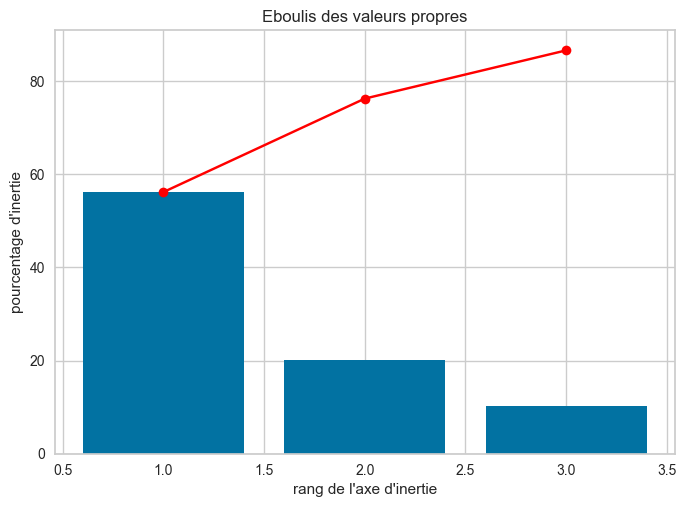

In [507]:
# Eboulis des valeurs propres
display_scree_plot(pca)

Les 4 premières composantes représentent plus de 85% de l'inertie.



### Cercles de corrélation

<Figure size 800x550 with 0 Axes>

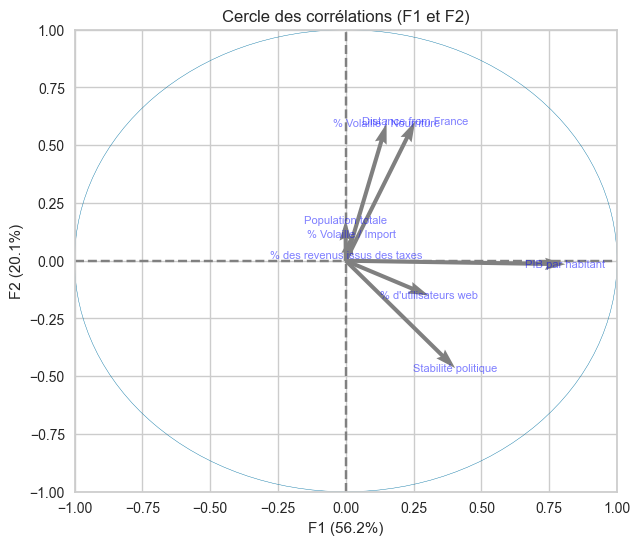

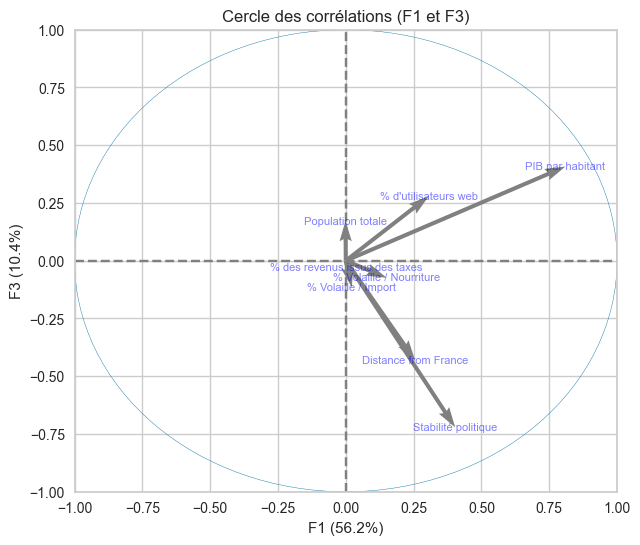

In [508]:
# Cercle des corrélations

plt.subplots_adjust(wspace=0.5)
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(0,2)], labels = np.array(features))

### Analyse des cercles de corrélation

Pour les deux cercles, nos variables se situent toutes dans la partie droite du cercle ce qui signifie qu'il n'y a aucune corrélations négatives.

Cercle F1 et F2 :

- L'axe F1 correspondrait aux pays les plus développés sur tous les points, stables et les plus ouverts au commerce
- L'axe F2 correspondrait aux pays les plus peuplés, ayant besoin de beaucoup de nourriture et qui par conséquent importent le plus. Ce sont aussi les plus éliignés de la France.

Cercle F1 et F3 : 
- L'axe F1 correspondrait aux pays les plus développés sur tous les points, stables, moins ouverts au commerce mais important beaucoup. Ils sont également plus éloignés de la France.
- L'axe F3 correspondrait aux pays les moins peuplés avec le plus bas niveau d'importation 

### Projection des individus

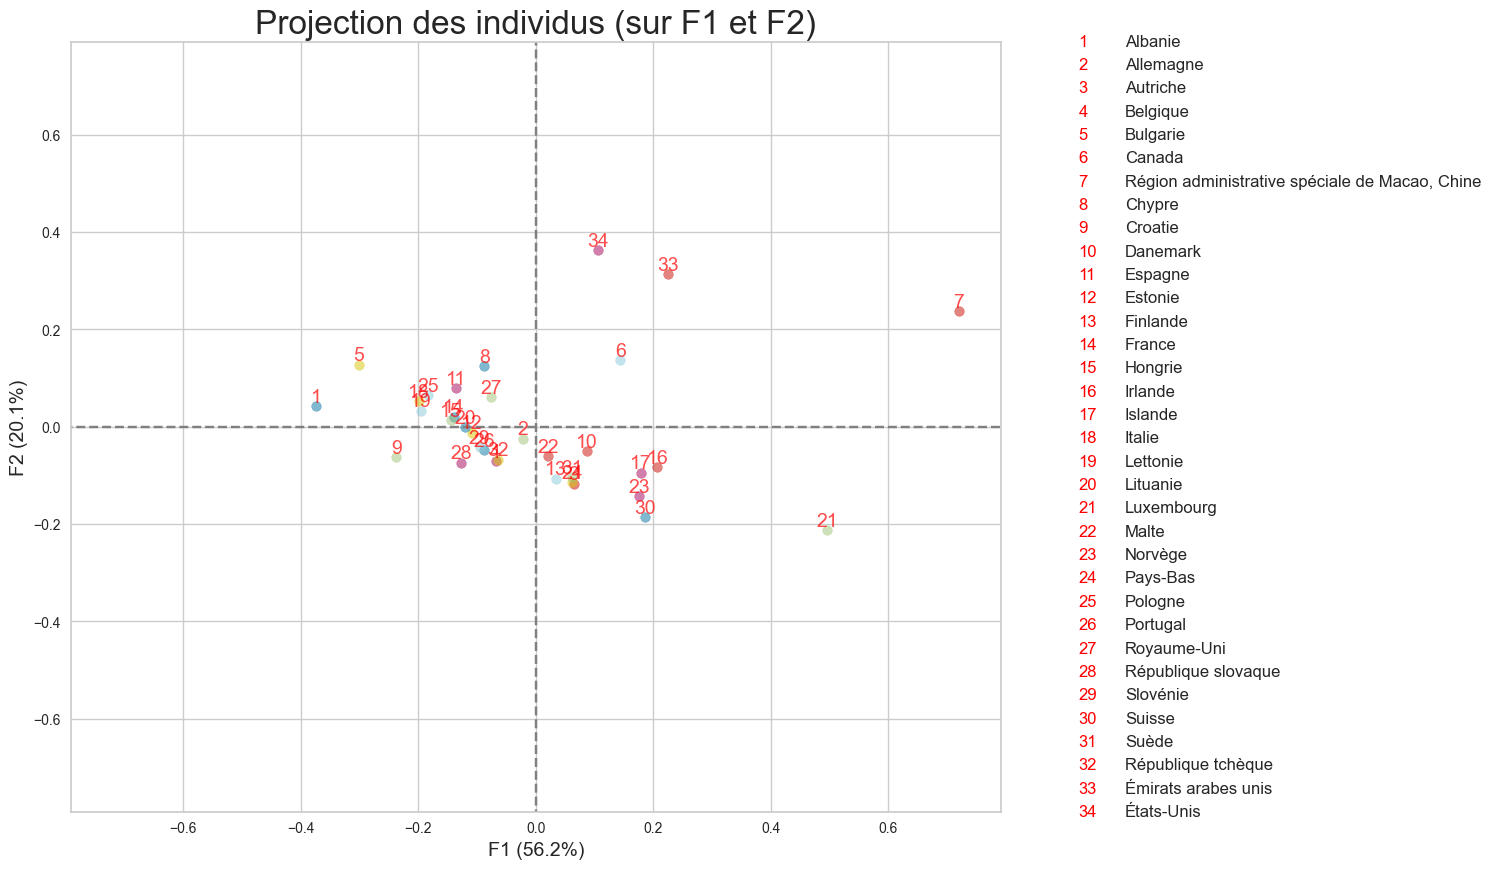

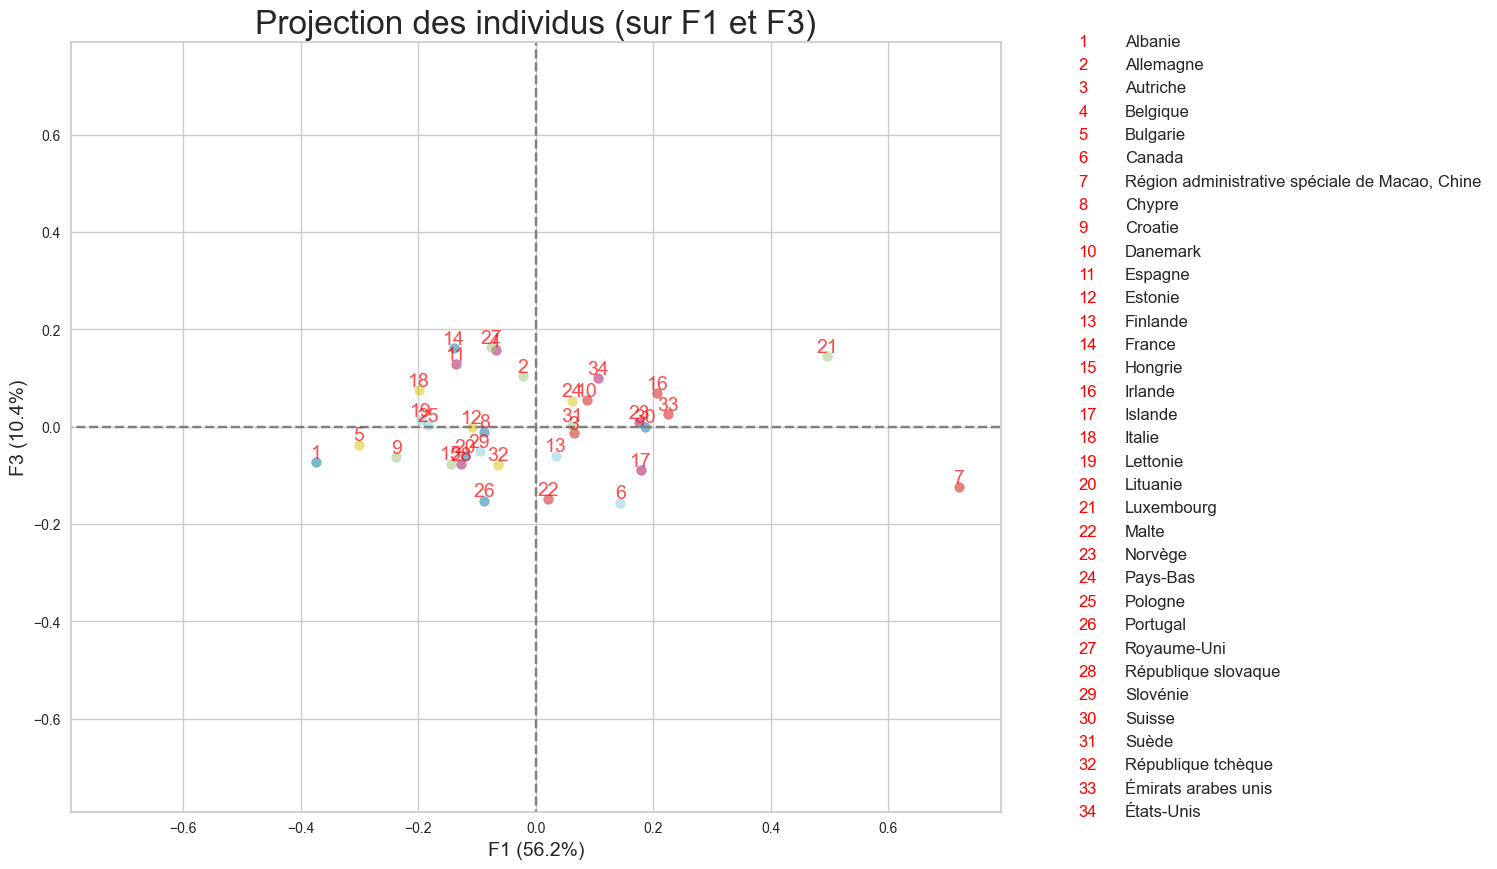

In [509]:
# Projection des individus 

df_projected = pca.transform(
    pd.DataFrame(cluster_final, index=cluster_final.index))
# On labellise un numéro à chaque nom de colonne
n_labels = [value for value in range(1, (len(cluster_final.index) + 1))]

display_factorial_planes(
    df_projected,
    n_comp,
    pca, [(0, 1), (0, 2)],
    alpha=0.5,
    labels=n_labels,
    illustrative_var=cluster_final.index.get_level_values('Zone'))


### Analyse des projections



Les pays les plus intéressant si l'on se fie à cette visualisation en fonction de nos cercles de corrélation seront :
- Sur la première projection : ceux sur la partie positive de F1 et la partie positive de F2 (USA, EAU, Canada, Macao)

- Sur la deuxième projection : tous les pays situés sur la partie positive de F1 et entre -0.2 et 0.2 sur l'axe F3 (USA, EAU, Canada, Macao, Autriche, Danemark, Finlande, Irlande, Islande, Luxembourg, Malte, Norvège, Pays-Bas, Suisse et Suède)